## Probability of Default Model

In [1]:
#import Libraries
import warnings
warnings.filterwarnings("ignore")
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [6]:
#display all columns
pd.options.display.max_columns = None

In [2]:
loan_data_backup = pd.read_parquet('loan_data/cleaned_data_with_dummies.parquet')

In [3]:
loan_data = loan_data_backup.copy()

In [4]:
loan_data.shape

(466285, 159)

In [7]:
loan_data.head(2)

,id,member_id,loan_amnt,funded_amnt,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,initial_list_status,total_rec_prncp,total_rec_int,recoveries,acc_now_delinq,total_rev_hi_lim,emp_length_int,term_int,earliest_cr_line_mnths,mnths_since_issue_date,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,1077501,1296599,5000,5000,10.65,162.87,B,B2,RENT,24000.0,Verified,Fully Paid,credit_card,860xx,AZ,27.65,0.0,1.0,0.0,0.0,3.0,0.0,9.0,f,5000.00,861.07,0.00,0.0,5000.0,10,36,395.0,72.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1077430,1314167,2500,2500,15.27,59.83,C,C4,RENT,30000.0,Source Verified,Charged Off,car,309xx,GA,1.00,0.0,5.0,0.0,0.0,3.0,0.0,4.0,f,456.46,435.17,117.08,0.0,2500.0,0,60,224.0,72.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Data Preperation

#### Dependent Variable, Good/Bad (Default) Definition, Default and Non-default Accounts.

**Default Definition**

Look at dataset for information about borrower performance and repayment behavior. This is found in the Loan_status column.
Default classification:
- 1 represents Good loan
- 0 represents Bad Loan
Reason for such classification: Model we'll use is a logistic regression model, and it'll help interpretability if positive coefficients represents good and negative coefficients represent bad loans.
    
All variables in our PD model will be dummy variables for interpretability.

In [8]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [9]:
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [12]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default', 
                                                               'Does not meet the credit policy. Status:Charged Off'
                                                               ,'Late (31-120 days)',]), 0, 1)

#### Splitting the data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = loan_data.drop('good_bad', axis=1)
y = loan_data['good_bad']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(373028, 159) (93257, 159) (373028,) (93257,)


#### Independent Variables

- continuous variables will be turned into categories using fine classing and coarse classing.
- Weight of evidence (which shows to what extent an independent variable would predict a dependent variable - log(%good/%bad))  will be used to perform coarse classing.
- Information Value, shows us how much information the original independent variable brings with respect to explaining the dependent variable ((%good - %bad) x WoE). This can be used for feature selection, values btw 0-0.02: no predictive power, 0.02-0.1: weak predictive power, 0.1-0.3: medium predictive power, 0.3-0.5: strong predictive power, and >0.5: suspiciously high(too good to be true).

##### Discrete variables

In [17]:
X_train['grade'].unique()

array(['A', 'D', 'B', 'F', 'C', 'E', 'G'], dtype=object)

In [37]:
#grade column has grade of credit rating value ranging from A-G, 
#IUA showing the highest credit worthiness and G showing the lowest.
df = pd.concat([X_train['grade'], y_train], axis=1)
df.head()

,grade,good_bad
456615,A,1
451541,D,1
394474,D,1
110294,A,1
139343,B,0


In [38]:
#group columns by grade
df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count()

,grade,good_bad
0,A,59810
1,B,109344
2,C,100342
3,D,61713
4,E,28590
5,F,10606
6,G,2623


In [39]:
#get mean of good observations by grade
df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1)

In [40]:
df

,grade,good_bad,grade,good_bad
0,A,59810,A,0.961361
1,B,109344,B,0.921422
2,C,100342,C,0.885870
3,D,61713,D,0.845527
4,E,28590,E,0.804477
5,F,10606,F,0.758061
6,G,2623,G,0.721693


In [41]:
df = df.iloc[: , [0, 1, 3]]
df

,grade,good_bad,good_bad
0,A,59810,0.961361
1,B,109344,0.921422
2,C,100342,0.885870
3,D,61713,0.845527
4,E,28590,0.804477
5,F,10606,0.758061
6,G,2623,0.721693


In [42]:
#change column names
df.columns = [df.columns.values[0], 'no_obs', 'prop_good']
df

,grade,n_obs,prop_good
0,A,59810,0.961361
1,B,109344,0.921422
2,C,100342,0.885870
3,D,61713,0.845527
4,E,28590,0.804477
5,F,10606,0.758061
6,G,2623,0.721693


In [43]:
# get proportion of all observations
df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()

In [44]:
df

,grade,n_obs,prop_good,prop_n_obs
0,A,59810,0.961361,0.160336
1,B,109344,0.921422,0.293125
2,C,100342,0.885870,0.268993
3,D,61713,0.845527,0.165438
4,E,28590,0.804477,0.076643
5,F,10606,0.758061,0.028432
6,G,2623,0.721693,0.007032


In [45]:
#get number of good borrowers and number of bad borrowers
df['n_good'] = df['prop_good'] * df['n_obs']
df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad
0,A,59810,0.961361,0.160336,57499.0,2311.0
1,B,109344,0.921422,0.293125,100752.0,8592.0
2,C,100342,0.885870,0.268993,88890.0,11452.0
3,D,61713,0.845527,0.165438,52180.0,9533.0
4,E,28590,0.804477,0.076643,23000.0,5590.0
5,F,10606,0.758061,0.028432,8040.0,2566.0
6,G,2623,0.721693,0.007032,1893.0,730.0


In [46]:
#calculate the proportions of good and bad borrowers for each grade
df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad
0,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678
1,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723
2,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801
4,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097
5,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932
6,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904


In [47]:
#calculate weight of evidence of the variable
df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232
1,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975
2,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915
4,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340
5,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774
6,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981


In [48]:
#sort table based on WoE
df = df.sort_values(['WoE'])
df = df.reset_index(drop = True)
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232


In [49]:
#calculate the differences in the proportion of good loans and WoE btw two subsequent categories
df['diff_prop_good'] = df['prop_good'].diff().abs()
df['diff_WoE'] = df['WoE'].diff().abs()
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257


In [50]:
#calculate information value, this is for the overall category
df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
df['IV'] = df['IV'].sum()
df

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


In [55]:
#create a function to automate the calculations for all categorical variables
def woe_discrete(df, discrete_variable_name, good_bad_variable):
    df = pd.concat([df[discrete_variable_name], good_bad_variable], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[: , [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**GRADE**

In [57]:
df_temp = woe_discrete(X_train, 'grade', y_train)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


In [60]:
#create charts to visualize weight of evidence
def plot_by_woe(df_WoE, rotation_of_x_axis_labels=0):
    x = np.array(df_WoE.iloc[: , 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x, y, marker='o', linestyle='--', color='k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation=rotation_of_x_axis_labels)

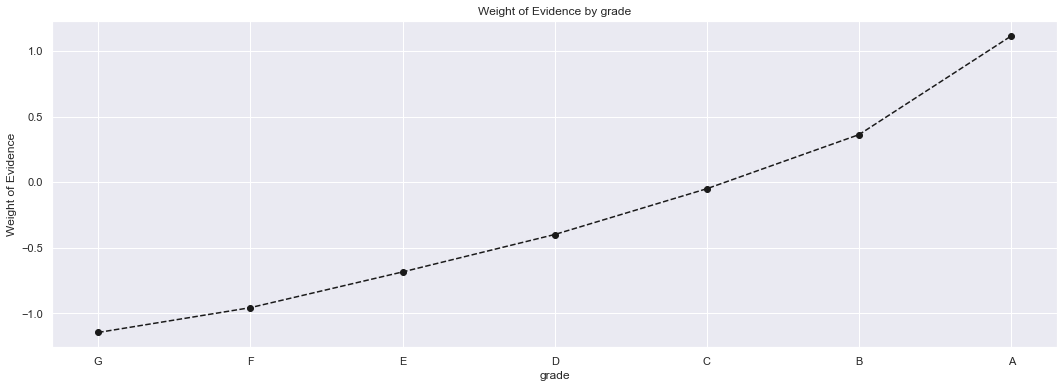

In [64]:
plot_by_woe(df_temp)

This shows that loans with greater external ratings are better on average

Thus for the grade variable, we'll have dummy variables for each of its categories.

**HOME_OWNERSHIP**

In [65]:
df_temp = woe_discrete(X_train, 'home_ownership', y_train)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,159,0.792453,0.000426,126.0,33.0,0.000379,0.000809,-0.758081,NaN,NaN,0.02166
1,NONE,41,0.853659,0.000110,35.0,6.0,0.000105,0.000147,-0.334267,0.061206,0.423814,0.02166
2,RENT,150776,0.874052,0.404195,131786.0,18990.0,0.396642,0.465738,-0.160588,0.020393,0.173678,0.02166
3,OWN,33313,0.890343,0.089304,29660.0,3653.0,0.089269,0.089591,-0.003605,0.016292,0.156984,0.02166
4,MORTGAGE,188739,0.904143,0.505965,170647.0,18092.0,0.513604,0.443714,0.146272,0.013800,0.149877,0.02166


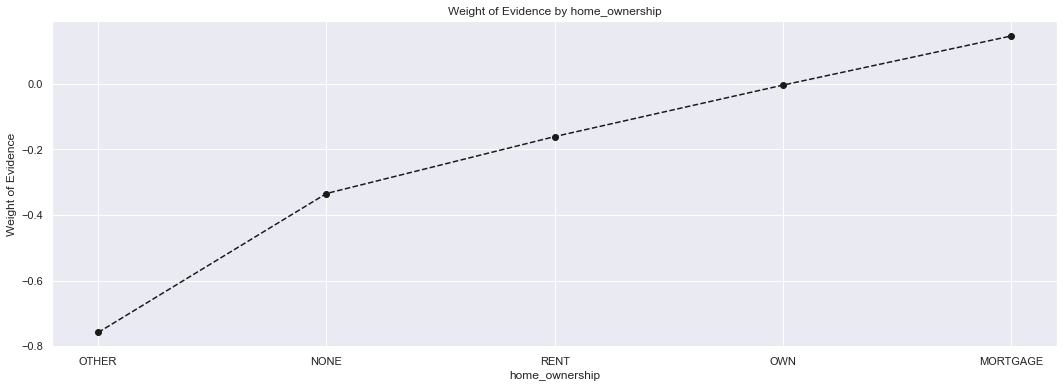

In [66]:
plot_by_woe(df_temp)

Other and None categories are asssociated with the highest probability of default, if we look at their proportion in the total number of observations in the dataset, it is quite low. So we'll combined such under represented categories with the riskiest category with enough number of observations i.e we'll combine dummies of other, none, and rent.

Thus for the home_ownership variable, we'll have one dummy variable for own, one for mortgage, and one for combined rent, other, and none

In [69]:
#creating the combined dummy variable
X_train['home_ownership:RENT_OTHER_NONE'] = sum([X_train['home_ownership:RENT'], X_train['home_ownership:OTHER'],
                                               X_train['home_ownership:NONE']])

STATE

In [70]:
df_temp = woe_discrete(X_train, 'addr_state', y_train)
df_temp

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NE,8,0.500000,0.000021,4.0,4.0,0.000012,0.000098,-2.097855,NaN,NaN,inf
1,IA,7,0.857143,0.000019,6.0,1.0,0.000018,0.000025,-0.306096,0.357143,1.791759,inf
2,NV,5238,0.863498,0.014042,4523.0,715.0,0.013613,0.017536,-0.253207,0.006355,0.052889,inf
3,FL,25259,0.873273,0.067713,22058.0,3201.0,0.066389,0.078506,-0.167643,0.009775,0.085564,inf
4,HI,2012,0.876740,0.005394,1764.0,248.0,0.005309,0.006082,-0.135945,0.003467,0.031698,inf
5,AL,4698,0.877607,0.012594,4123.0,575.0,0.012409,0.014102,-0.127889,0.000868,0.008056,inf
6,MD,8811,0.882874,0.023620,7779.0,1032.0,0.023413,0.025310,-0.077926,0.005266,0.049963,inf
7,OK,3301,0.883369,0.008849,2916.0,385.0,0.008776,0.009442,-0.073130,0.000495,0.004796,inf
8,NY,32111,0.884339,0.086082,28397.0,3714.0,0.085468,0.091087,-0.063681,0.000970,0.009449,inf
9,NM,2077,0.884449,0.005568,1837.0,240.0,0.005529,0.005886,-0.062605,0.000110,0.001076,inf


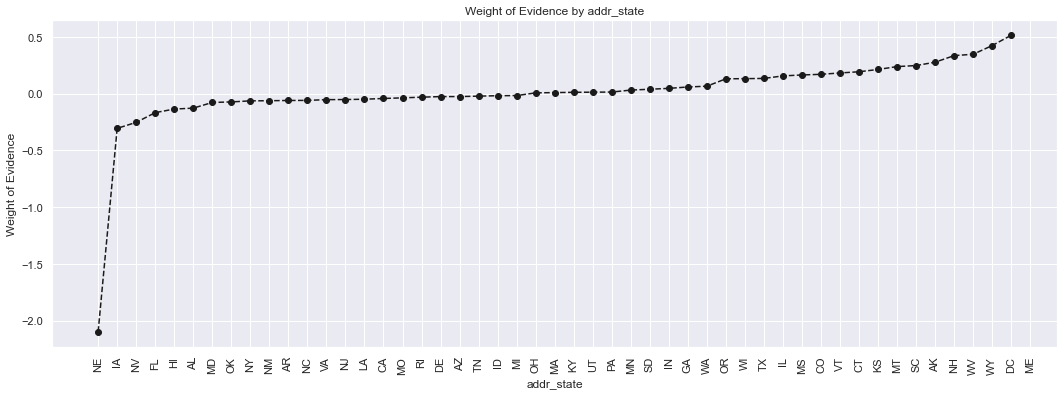

In [71]:
plot_by_woe(df_temp, rotation_of_x_axis_labels=90)

In [72]:
#create a dummy variabe for north dakota in case of future purposes
if ['addr_state:ND'] in X_train.columns.values:
    pass
else:
    X_train['addr_state:ND'] = 0

In the graph, there are two states with a considerably low WoE compared to other states - NE and IA, and one state with a considerably high WoE - ME. ME also doesn't have IV values because there where no bad borrowers.<br>
In the result table, the first two and the last one have extremely low number of observations, so it doesn't make sense to leave them in categories of their own. It's also likely that the low numbers are the reason for their extreme WoE values. <br>
We'll include these states in the first - the worst, and the last - the best category respectively.

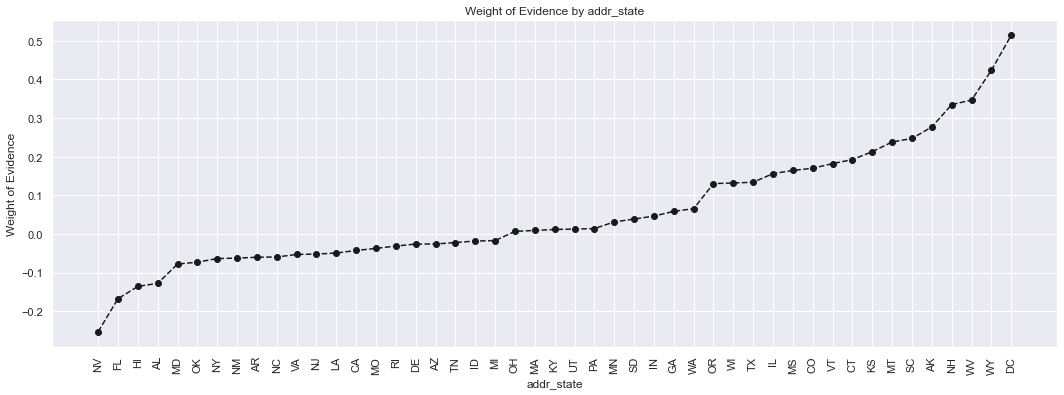

In [73]:
#focusing on the other 47 states
plot_by_woe(df_temp.iloc[2:-1, :], rotation_of_x_axis_labels=90)

Now we can see the difference in the WoE for each state:
- NV has a considerably low WoE, while FL, HI and AL have similar WoE. It would make sense to keep NV in its own category and combine the similar to create a single category. However, the number of observation for NV is relatively small, and that of FL is relatively large to be placed in a category of it's own. So we'll combine NV and FL to make a category for this reason, wé'll add HI and AL to it due to their small number of observations, we'll also including the NE and IA which has the least no of observations, and ND - the category we have no information for.
- we'll also combine the states with the highest WoE - NH, WV, WY and DC based on their low number of observations, also including ME which had the highest WoE with no bad borrowers.

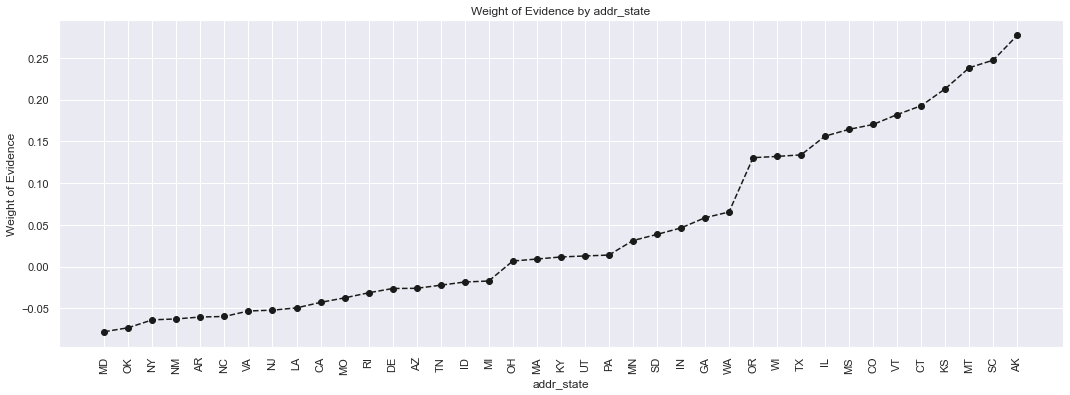

In [74]:
#looking at the remaining 37 states
plot_by_woe(df_temp.iloc[6:-5, :], rotation_of_x_axis_labels=90)

In the graph of the remaining 37 states:
- MD to CA seem to have similar WoE, but in the table statistics we see that NewYork NY and California CA have relatively high number of observations, so we'll but them in separate groups. MD and OK would be in one group, NY would be in a category of it's own, NM to LA would be in a group, and CA would be in a category of it's own.
- states MO to MI have similar WoE and don't have any state with uniquely high number of observations, so we'll group them together
- states OH to PA have similar WoE so we'll group them together
- states MN to WA have similar WoE so we'll group them together
- states OR to TX have similar WoE but because TX has a very high number of observations, we'll leave it in a category of its own and group OR and WI together
- we'll group IL to CO together in one group, and VT to AK in one group due to their low number of observations.

In [77]:
#let's create the dummy variable categories
X_train['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_train['addr_state:ND'], X_train['addr_state:NE'], X_train['addr_state:IA'],
                                                  X_train['addr_state:NV'], X_train['addr_state:FL'], X_train['addr_state:HI'],
                                                  X_train['addr_state:AL']])
X_train['addr_state:NH_WV_WY_DC_ME'] = sum([X_train['addr_state:NH'], X_train['addr_state:WV'], X_train['addr_state:WY'],
                                            X_train['addr_state:DC'], X_train['addr_state:ME']])
X_train['addr_state:MD_OK'] = sum([X_train['addr_state:MD'], X_train['addr_state:OK']])
X_train['addr_state:NM_AR_NC_VA_NJ_LA'] = sum([X_train['addr_state:NM'], X_train['addr_state:AR'], X_train['addr_state:NC'],
                                               X_train['addr_state:VA'], X_train['addr_state:NJ'], X_train['addr_state:LA']])
X_train['addr_state:MO_RI_DE_AZ_TN_ID_MI'] = sum([X_train['addr_state:MO'], X_train['addr_state:RI'], X_train['addr_state:DE'],
                                                  X_train['addr_state:AZ'], X_train['addr_state:TN'], X_train['addr_state:ID'],
                                                  X_train['addr_state:MI']])
X_train['addr_state:OH_MA_KY_UT_PA'] = sum([X_train['addr_state:OH'], X_train['addr_state:MA'], X_train['addr_state:KY'],
                                            X_train['addr_state:UT'], X_train['addr_state:PA']])
X_train['addr_state:MN_SD_IN_GA_WA'] = sum([X_train['addr_state:MN'], X_train['addr_state:SD'], X_train['addr_state:IN'],
                                            X_train['addr_state:GA'], X_train['addr_state:WA']])
X_train['addr_state:OR_WI'] = sum([X_train['addr_state:OR'], X_train['addr_state:WI']])
X_train['addr_state:IL_MS_CO'] = sum([X_train['addr_state:IL'], X_train['addr_state:MS'], X_train['addr_state:CO']])
X_train['addr_state:VT_CT_KS_MT_SC_AK'] = sum([X_train['addr_state:VT'], X_train['addr_state:CT'], X_train['addr_state:KS'],
                                               X_train['addr_state:MT'], X_train['addr_state:SC'], X_train['addr_state:AK']])

##### Continuous variables

In [83]:
#create a function to automate the calculations for all continuous variables
def woe_ordered_continuous(df, discrete_variable_name, good_bad_variable):
    df = pd.concat([df[discrete_variable_name], good_bad_variable], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[: , [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    #order by values because we want to preserve the natural order of variable
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**TERM**

In [84]:
X_train['term_int'].unique()

array([36, 60])

In [86]:
df_temp = woe_ordered_continuous(X_train, 'term_int', y_train)
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270199,0.903238,0.72434,244054.0,26145.0,0.73454,0.641217,0.135876,NaN,NaN,0.040794
1,60,102829,0.857735,0.27566,88200.0,14629.0,0.26546,0.358783,-0.301254,0.045503,0.43713,0.040794


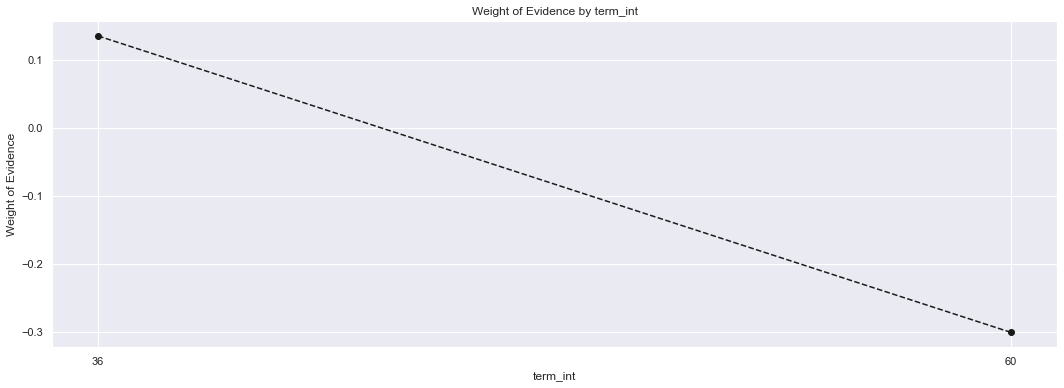

In [87]:
plot_by_woe(df_temp)

It seems loans with 60 months term are riskier than loans with 36 months, the only thing we can do is keep both categories

In [88]:
#creating the dummy variiables
X_train['term:36'] = np.where((X_train['term_int'] == 36), 1, 0)
X_train['term:60'] = np.where((X_train['term_int'] == 60), 1, 0)

**EMLOYMENT LENGTH**

In [89]:
X_train['emp_length_int'].unique()

array([ 7, 10,  3,  4,  2,  0,  1,  6,  5,  8,  9])

In [90]:
df_temp = woe_ordered_continuous(X_train, 'emp_length_int', y_train)
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0,45764,0.876497,0.122682,40112.0,5652.0,0.120727,0.138618,-0.138189,NaN,NaN,0.006408
1,1,23582,0.888262,0.063218,20947.0,2635.0,0.063045,0.064625,-0.024743,0.011765,0.113446,0.006408
2,2,33123,0.889895,0.088795,29476.0,3647.0,0.088715,0.089444,-0.008184,0.001633,0.016559,0.006408
3,3,29301,0.890925,0.078549,26105.0,3196.0,0.078569,0.078383,0.002372,0.001030,0.010555,0.006408
4,4,22482,0.891602,0.060269,20045.0,2437.0,0.060330,0.059768,0.009357,0.000677,0.006985,0.006408
5,5,24654,0.885374,0.066092,21828.0,2826.0,0.065697,0.069309,-0.053524,0.006229,0.062881,0.006408
6,6,21057,0.883079,0.056449,18595.0,2462.0,0.055966,0.060382,-0.075936,0.002294,0.022413,0.006408
7,7,20834,0.887204,0.055851,18484.0,2350.0,0.055632,0.057635,-0.035365,0.004124,0.040571,0.006408
8,8,17859,0.889300,0.047876,15882.0,1977.0,0.047801,0.048487,-0.014249,0.002096,0.021116,0.006408
9,9,14372,0.887142,0.038528,12750.0,1622.0,0.038374,0.039780,-0.035984,0.002158,0.021735,0.006408


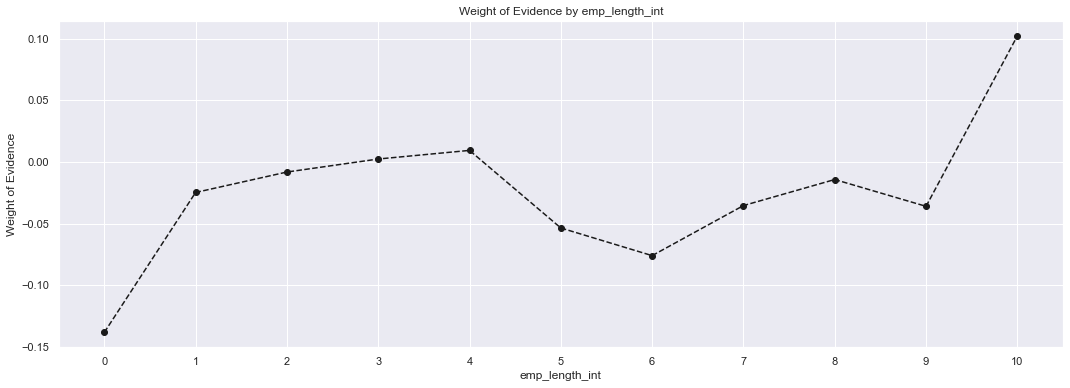

In [91]:
plot_by_woe(df_temp)

From the graph above, we'll create the following categories:
- 0 years of employment will have a category of it's own
- 1 year will have a category of it's own
- years 2-4 will have a category of it's own due to it's similar WoE
- years 5-6 will have a category of it's own due to it's similar WoE
- years 7-9 will have a category of it's own
- 10 years will have a category of it's own

In [92]:
X_train['emp_length_int:0'] = np.where((X_train['emp_length_int'].isin([0])), 1, 0)
X_train['emp_length_int:1'] = np.where((X_train['emp_length_int'].isin([1])), 1, 0)
X_train['emp_length_int:2-4'] = np.where((X_train['emp_length_int'].isin(range(2, 5))), 1, 0)
X_train['emp_length_int:5-6'] = np.where((X_train['emp_length_int'].isin(range(5, 7))), 1, 0)
X_train['emp_length_int:7-9'] = np.where((X_train['emp_length_int'].isin(range(7, 10))), 1, 0)
X_train['emp_length_int:10'] = np.where((X_train['emp_length_int'].isin([10])), 1, 0)

**MONTHS SINCE ISSUE DATE**

In [94]:
X_train['mnths_since_issue_date'].unique()

array([ 47.,  43.,  52.,  55.,  37.,  40.,  41.,  49.,  44.,  72.,  38.,
        61.,  76.,  51.,  58.,  54.,  59., 105.,  74.,  56.,  75.,  53.,
        68.,  62.,  39.,  45.,  64.,  48.,  73.,  42.,  81.,  57.,  89.,
        70.,  71.,  36.,  50.,  46., 118.,  79.,  63.,  90.,  88.,  67.,
        60.,  78.,  82.,  84.,  96.,  69.,  83.,  97., 125., 107., 103.,
        66.,  65.,  86.,  77.,  92.,  80.,  98.,  94., 119.,  91., 117.,
        87., 102., 116., 109.,  85., 110.,  95.,  99., 115., 101., 112.,
       120., 104., 113., 100.,  93., 106., 121., 122., 108., 124., 114.,
       123., 111., 126.])

In [95]:
#performing fine classing
X_train['mnths_since_issue_date_factor'] = pd.cut(X_train['mnths_since_issue_date'], 50)

In [96]:
X_train['mnths_since_issue_date_factor']

456615      (46.8, 48.6]
451541      (46.8, 48.6]
394474      (41.4, 43.2]
110294      (50.4, 52.2]
139343      (54.0, 55.8]
               ...      
163633      (57.6, 59.4]
399306      (41.4, 43.2]
57787       (48.6, 50.4]
81641       (48.6, 50.4]
38736     (113.4, 115.2]
Name: mnths_since_issue_date_factor, Length: 373028, dtype: category
Categories (50, interval[float64, right]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

In [97]:
df_temp = woe_ordered_continuous(X_train, 'mnths_since_issue_date_factor', y_train)
df_temp

,mnths_since_issue_date_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(35.91, 37.8]",28350,0.942187,0.076000,26711.0,1639.0,0.080393,0.040197,0.693134,NaN,NaN,0.111991
1,"(37.8, 39.6]",39515,0.928660,0.105930,36696.0,2819.0,0.110446,0.069137,0.468430,0.013527,0.224704,0.111991
2,"(39.6, 41.4]",38298,0.917594,0.102668,35142.0,3156.0,0.105768,0.077402,0.312236,0.011066,0.156194,0.111991
3,"(41.4, 43.2]",29136,0.907297,0.078107,26435.0,2701.0,0.079563,0.066243,0.183212,0.010297,0.129025,0.111991
4,"(43.2, 45.0]",28449,0.902211,0.076265,25667.0,2782.0,0.077251,0.068230,0.124181,0.005086,0.059031,0.111991
5,"(45.0, 46.8]",12231,0.898046,0.032788,10984.0,1247.0,0.033059,0.030583,0.077844,0.004165,0.046337,0.111991
6,"(46.8, 48.6]",24497,0.896232,0.065671,21955.0,2542.0,0.066079,0.062344,0.058189,0.001814,0.019655,0.111991
7,"(48.6, 50.4]",23122,0.889240,0.061985,20561.0,2561.0,0.061883,0.062810,-0.014857,0.006993,0.073045,0.111991
8,"(50.4, 52.2]",20565,0.880866,0.055130,18115.0,2450.0,0.054522,0.060087,-0.097203,0.008374,0.082346,0.111991
9,"(52.2, 54.0]",18305,0.868342,0.049071,15895.0,2410.0,0.047840,0.059106,-0.211477,0.012524,0.114274,0.111991


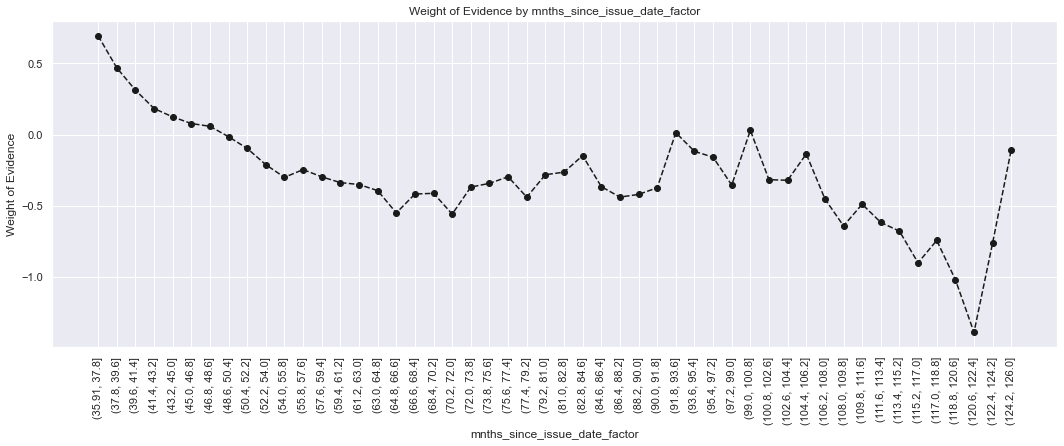

In [99]:
plot_by_woe(df_temp, rotation_of_x_axis_labels=90)

From the graph above, we'll create the following categories:
- < 38 months since issue date
- 38-39 months since issue date
- 40-41 months since issue date.
These three have rather high WoE, and would be good to plot individually

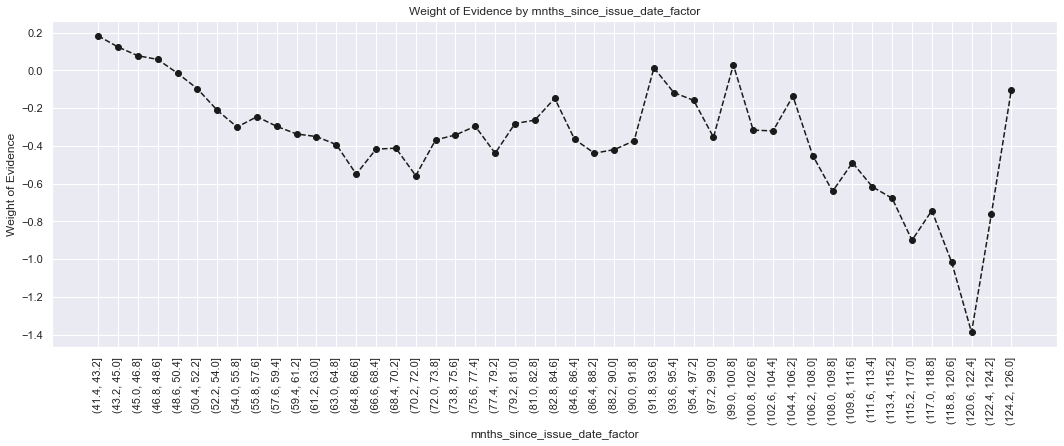

In [100]:
#looking at the other classes
plot_by_woe(df_temp.iloc[3: , :], 90)

we'll create categories for:
- 42-48 months since issue date, based on their similar WoE
- 49-52 months since issue date
- 53-64 months since issue date
- 65-84 months since issue date
- greater than 84 months since issue date, due to their small number of observations

In [106]:
X_train['mnths_since_issue_date:<38'] = np.where((X_train['mnths_since_issue_date'].isin(range(38))), 1, 0)
X_train['mnths_since_issue_date:38-39'] = np.where((X_train['mnths_since_issue_date'].isin(range(38, 40))), 1, 0)
X_train['mnths_since_issue_date:40-41'] = np.where((X_train['mnths_since_issue_date'].isin(range(40, 42))), 1, 0)
X_train['mnths_since_issue_date:42-48'] = np.where((X_train['mnths_since_issue_date'].isin(range(42, 49))), 1, 0)
X_train['mnths_since_issue_date:49-52'] = np.where((X_train['mnths_since_issue_date'].isin(range(49, 53))), 1, 0)
X_train['mnths_since_issue_date:53-64'] = np.where((X_train['mnths_since_issue_date'].isin(range(53, 65))), 1, 0)
X_train['mnths_since_issue_date:65-84'] = np.where((X_train['mnths_since_issue_date'].isin(range(65, 85))), 1, 0)
X_train['mnths_since_issue_date:>84'] = np.where((X_train['mnths_since_issue_date'].isin(range(85, int(X_train['mnths_since_issue_date'].max())))), 1, 0)

**INTEREST RATE**

In [108]:
X_train['int_rate_factor'] = pd.cut(X_train['int_rate'], 50)

In [111]:
df_temp = woe_ordered_continuous(X_train, 'int_rate_factor', y_train)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",776,0.962629,0.002080,747.0,29.0,0.002248,0.000711,1.150914,NaN,NaN,0.346603
1,"(5.833, 6.246]",8408,0.979305,0.022540,8234.0,174.0,0.024782,0.004267,1.759117,0.016677,0.608203,0.346603
2,"(6.246, 6.658]",7842,0.971181,0.021023,7616.0,226.0,0.022922,0.005543,1.419616,0.008125,0.339500,0.346603
3,"(6.658, 7.071]",1777,0.969612,0.004764,1723.0,54.0,0.005186,0.001324,1.364983,0.001569,0.054633,0.346603
4,"(7.071, 7.484]",3186,0.976146,0.008541,3110.0,76.0,0.009360,0.001864,1.613790,0.006534,0.248806,0.346603
5,"(7.484, 7.897]",12590,0.963781,0.033751,12134.0,456.0,0.036520,0.011184,1.183419,0.012365,0.430371,0.346603
6,"(7.897, 8.31]",9680,0.949483,0.025950,9191.0,489.0,0.027663,0.011993,0.835762,0.014297,0.347656,0.346603
7,"(8.31, 8.722]",6666,0.965047,0.017870,6433.0,233.0,0.019362,0.005714,1.220303,0.015563,0.384540,0.346603
8,"(8.722, 9.135]",9578,0.938923,0.025676,8993.0,585.0,0.027067,0.014347,0.634735,0.026124,0.585568,0.346603
9,"(9.135, 9.548]",6563,0.965565,0.017594,6337.0,226.0,0.019073,0.005543,1.235771,0.026642,0.601036,0.346603


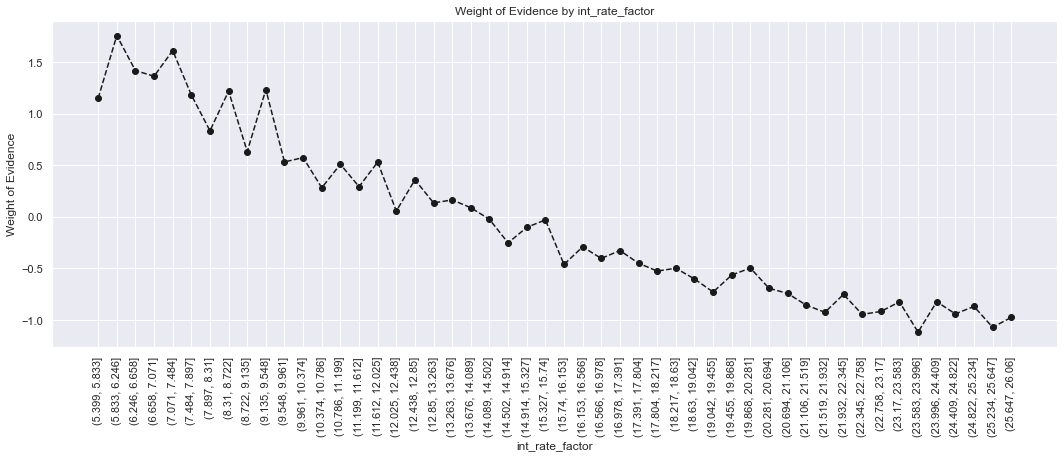

In [112]:
plot_by_woe(df_temp, 90)

From the graph we can se that as interest rate increases, the risk of default increases. We'll group the following categories based on WoE values and number of observations:
- interest rate <9.548
- interest rate from 9.548-12.025
- interest rate from 12.025-15.74
- interest rate from 15.74-20.281
- interest rate >20.281

In [113]:
X_train['int_rate:<9.548'] = np.where((X_train['int_rate'] <= 9.548), 1, 0)
X_train['int_rate:9.548-12.025'] = np.where((X_train['int_rate'] > 9.548) & (X_train['int_rate'] < 12.025), 1, 0)
X_train['int_rate:12.025-15.74'] = np.where((X_train['int_rate'] > 12.025) & (X_train['int_rate'] < 15.74), 1, 0)
X_train['int_rate:15.74-20.281'] = np.where((X_train['int_rate'] > 15.74) & (X_train['int_rate'] < 20.281), 1, 0)
X_train['int_rate:>20.281'] = np.where((X_train['int_rate'] > 20.281), 1, 0)

**FUNDED AMOUNT**

In [114]:
X_train['funded_amnt_factor'] = pd.cut(X_train['funded_amnt'], 50)

In [115]:
df_temp = woe_ordered_continuous(X_train, 'funded_amnt_factor', y_train)
df_temp

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 1190.0]",1241,0.900081,0.003327,1117.0,124.0,0.003362,0.003041,0.100265,NaN,NaN,0.014394
1,"(1190.0, 1880.0]",3086,0.904407,0.008273,2791.0,295.0,0.008400,0.007235,0.149325,0.004326,0.049060,0.014394
2,"(1880.0, 2570.0]",6047,0.895981,0.016211,5418.0,629.0,0.016307,0.015426,0.055496,0.008426,0.093829,0.014394
3,"(2570.0, 3260.0]",7255,0.891247,0.019449,6466.0,789.0,0.019461,0.019351,0.005692,0.004734,0.049804,0.014394
4,"(3260.0, 3950.0]",4756,0.889613,0.012750,4231.0,525.0,0.012734,0.012876,-0.011060,0.001634,0.016751,0.014394
5,"(3950.0, 4640.0]",9054,0.890104,0.024272,8059.0,995.0,0.024256,0.024403,-0.006053,0.000491,0.005007,0.014394
6,"(4640.0, 5330.0]",15927,0.894770,0.042697,14251.0,1676.0,0.042892,0.041105,0.042562,0.004666,0.048615,0.014394
7,"(5330.0, 6020.0]",17206,0.906486,0.046125,15597.0,1609.0,0.046943,0.039461,0.173611,0.011716,0.131049,0.014394
8,"(6020.0, 6710.0]",6910,0.886541,0.018524,6126.0,784.0,0.018438,0.019228,-0.041967,0.019945,0.215577,0.014394
9,"(6710.0, 7400.0]",11745,0.897829,0.031486,10545.0,1200.0,0.031738,0.029431,0.075475,0.011288,0.117442,0.014394


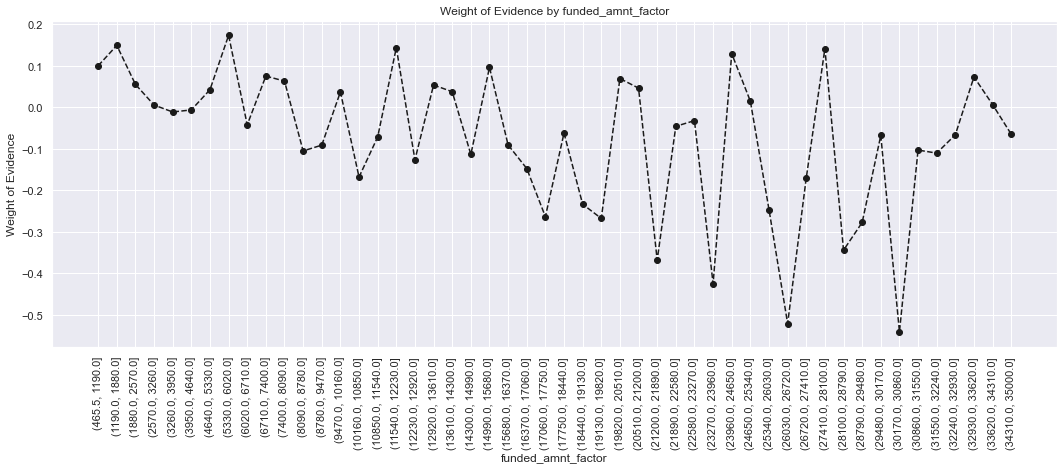

In [116]:
plot_by_woe(df_temp, 90)

In this graph, the WoE for each category differs greatly, and there seems to be no association between 'funded amount' and WoE. So we won't use the funded amount column in our PD Model.

**ANNUAL INCOME**

In [118]:
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 100)

In [119]:
df_temp = woe_ordered_continuous(X_train, 'annual_inc_factor', y_train)
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-5602.104, 76877.04]",245053,0.877480,0.656929,215029.0,30024.0,0.647183,0.736352,-0.129079,NaN,NaN,inf
1,"(76877.04, 151858.08]",111580,0.914555,0.299120,102046.0,9534.0,0.307132,0.233825,0.272704,0.037075,0.401783,inf
2,"(151858.08, 226839.12]",11948,0.924590,0.032030,11047.0,901.0,0.033249,0.022097,0.408554,0.010035,0.135850,inf
3,"(226839.12, 301820.16]",2848,0.926966,0.007635,2640.0,208.0,0.007946,0.005101,0.443141,0.002376,0.034587,inf
4,"(301820.16, 376801.2]",689,0.925980,0.001847,638.0,51.0,0.001920,0.001251,0.428658,0.000987,0.014483,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(7125094.8, 7200075.84]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,NaN,NaN,inf
96,"(7200075.84, 7275056.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(7275056.88, 7350037.92]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(7350037.92, 7425018.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


The number of observations of the first two are very large, and become smaller as annual income increases. We'll create one dummy variable for people with large income, and figure out what dummies to create for people with lower income.
The third group with 11,948 number of observations start at \\$151,858 dollars, so we'll assume that \\$150,000 is the threshhold above which people are considered to have high income.

In [120]:
X_train_temp = X_train.loc[X_train['annual_inc'] <= 150000, :]

In [121]:
X_train_temp['annual_inc_factor'] = pd.cut(X_train_temp['annual_inc'], 50)

In [122]:
df_temp = woe_ordered_continuous(X_train_temp, 'annual_inc_factor', y_train[X_train_temp.index])
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1747.896, 4858.08]",16,0.812500,0.000045,13.0,3.0,0.000041,0.000076,-0.614901,NaN,NaN,0.049061
1,"(4858.08, 7820.16]",45,0.822222,0.000126,37.0,8.0,0.000117,0.000202,-0.549762,0.009722,0.065139,0.049061
2,"(7820.16, 10782.24]",342,0.847953,0.000959,290.0,52.0,0.000915,0.001315,-0.362601,0.025731,0.187161,0.049061
3,"(10782.24, 13744.32]",696,0.824713,0.001952,574.0,122.0,0.001811,0.003085,-0.532630,0.023241,0.170029,0.049061
4,"(13744.32, 16706.4]",1392,0.847701,0.003905,1180.0,212.0,0.003723,0.005361,-0.364555,0.022989,0.168075,0.049061
5,"(16706.4, 19668.48]",1908,0.849057,0.005352,1620.0,288.0,0.005111,0.007282,-0.354017,0.001355,0.010538,0.049061
6,"(19668.48, 22630.56]",3592,0.843820,0.010076,3031.0,561.0,0.009563,0.014185,-0.394311,0.005237,0.040294,0.049061
7,"(22630.56, 25592.64]",6450,0.859380,0.018093,5543.0,907.0,0.017488,0.022934,-0.271090,0.015560,0.123222,0.049061
8,"(25592.64, 28554.72]",5729,0.848316,0.016070,4860.0,869.0,0.015334,0.021973,-0.359788,0.011064,0.088698,0.049061
9,"(28554.72, 31516.8]",10353,0.858881,0.029041,8892.0,1461.0,0.028055,0.036942,-0.275208,0.010566,0.084580,0.049061


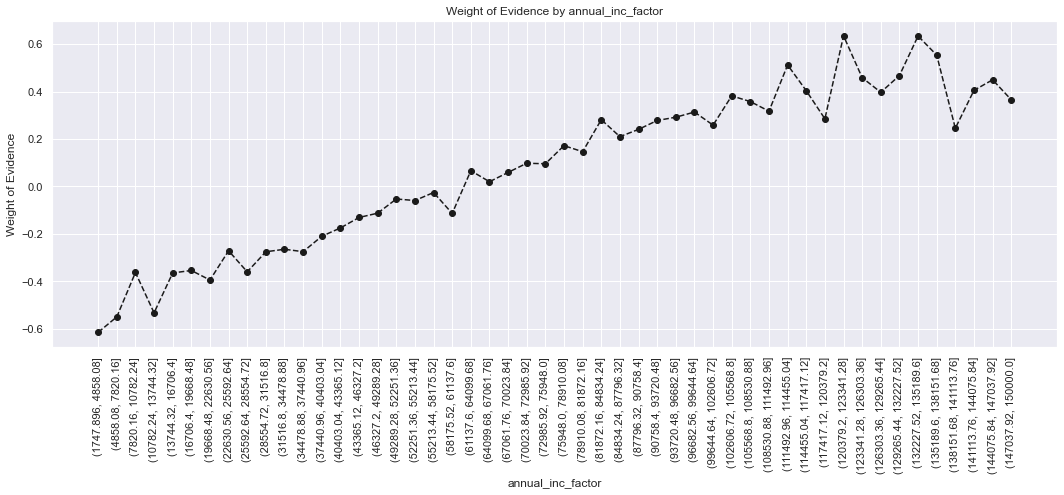

In [123]:
plot_by_woe(df_temp, 90)

From the graph, WoE increases monotonously as income increases.
We'll group the following categories based on WoE values and number of observations:
- We can split the annual_inc variable equally with width of 10,000 but the first 3 rows will be bunched together, and they all have few no of observations based on. so the first category will be <=20k
- if we kept the rest split equally with a width of 10,000, the last four intervals from 105568.8 will have very small no of observations. so we'll make two intervals, of 100k-120k and 120k-150k
- Now we're left with values between 20k and 100k, we'll split it into equally wide categories with width of 10,000 each. so we'll have 8 equal categories.

In [124]:
#creating the dummy variables
X_train['annual_inc:<20k'] = np.where((X_train['annual_inc'] <= 20000), 1, 0)
X_train['annual_inc:20k-30k'] = np.where((X_train['annual_inc'] > 20000) & (X_train['annual_inc'] <= 30000), 1, 0)
X_train['annual_inc:30k-40k'] = np.where((X_train['annual_inc'] > 30000) & (X_train['annual_inc'] <= 40000), 1, 0)
X_train['annual_inc:40k-50k'] = np.where((X_train['annual_inc'] > 40000) & (X_train['annual_inc'] <= 50000), 1, 0)
X_train['annual_inc:50k-60k'] = np.where((X_train['annual_inc'] > 50000) & (X_train['annual_inc'] <= 60000), 1, 0)
X_train['annual_inc:60k-70k'] = np.where((X_train['annual_inc'] > 60000) & (X_train['annual_inc'] <= 70000), 1, 0)
X_train['annual_inc:70k-80k'] = np.where((X_train['annual_inc'] > 70000) & (X_train['annual_inc'] <= 80000), 1, 0)
X_train['annual_inc:80k-90k'] = np.where((X_train['annual_inc'] > 80000) & (X_train['annual_inc'] <= 90000), 1, 0)
X_train['annual_inc:90k-100k'] = np.where((X_train['annual_inc'] > 90000) & (X_train['annual_inc'] <= 100000), 1, 0)
X_train['annual_inc:100k-120k'] = np.where((X_train['annual_inc'] > 100000) & (X_train['annual_inc'] <= 120000), 1, 0)
X_train['annual_inc:120k-150k'] = np.where((X_train['annual_inc'] > 120000) & (X_train['annual_inc'] <= 150000), 1, 0)
X_train['annual_inc:>150k'] = np.where((X_train['annual_inc'] > 150000), 1, 0)

**MONTHS SINCE LAST DELINQUENCY**

In [125]:
X_train['mths_since_last_delinq'].unique()

array([ 20.,   0.,  10.,  70.,  12.,  64.,  75.,  34.,  62.,   3.,   4.,
        27.,  45.,  37.,  32.,  26.,  51.,  76.,  19.,  42.,  24.,  18.,
         8.,   9.,  36.,  14.,  29.,  11.,  16.,  72.,  23.,   6.,  63.,
        44.,  59.,  46.,  60.,  81.,  41.,  15.,   1.,  31.,  17.,  28.,
         7.,  57.,  22.,  54.,  74.,   5.,  30.,  80.,  55.,  13.,   2.,
        48.,  50.,  21.,  25.,  39.,  33.,  73.,  49.,  38.,  35.,  52.,
        67.,  40.,  47.,  61.,  43.,  68.,  56.,  77.,  58.,  71.,  82.,
        53.,  79.,  78.,  69.,  66.,  65.,  84., 180., 104.,  87., 105.,
        83., 136.,  92.,  85., 133.,  86., 106.,  90.,  97.,  96.,  93.,
        99.,  88.,  91.,  98.,  95., 103., 100., 101., 114., 135., 122.,
       131., 140.,  89., 107., 148.,  94., 121., 134., 110., 141., 156.,
       127., 102., 143., 115., 152., 111., 113., 188., 159., 151., 130.,
       129., 119., 120., 146., 170., 118., 139., 116.])

In [128]:
X_train['mths_since_last_delinq'].isnull().sum()

0

In [126]:
X_train['mths_since_last_delinq_factor'] = pd.cut(X_train['mths_since_last_delinq'], 50)

In [127]:
df_temp = woe_ordered_continuous(X_train, 'mths_since_last_delinq_factor', y_train)
df_temp

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.188, 3.76]",205632,0.889224,0.551251,182853.0,22779.0,0.550341,0.558665,-0.015012,NaN,NaN,inf
1,"(3.76, 7.52]",11070,0.884914,0.029676,9796.0,1274.0,0.029483,0.031245,-0.058043,0.004310,0.043031,inf
2,"(7.52, 11.28]",13371,0.891257,0.035844,11917.0,1454.0,0.035867,0.035660,0.005792,0.006343,0.063835,inf
3,"(11.28, 15.04]",13272,0.885398,0.035579,11751.0,1521.0,0.035368,0.037303,-0.053285,0.005859,0.059077,inf
4,"(15.04, 18.8]",9267,0.896622,0.024843,8309.0,958.0,0.025008,0.023495,0.062392,0.011225,0.115676,inf
5,"(18.8, 22.56]",11640,0.892612,0.031204,10390.0,1250.0,0.031271,0.030657,0.019845,0.004011,0.042547,inf
6,"(22.56, 26.32]",10918,0.895860,0.029269,9781.0,1137.0,0.029438,0.027885,0.054193,0.003248,0.034348,inf
7,"(26.32, 30.08]",10557,0.894099,0.028301,9439.0,1118.0,0.028409,0.027419,0.035454,0.001761,0.018740,inf
8,"(30.08, 33.84]",7548,0.899974,0.020234,6793.0,755.0,0.020445,0.018517,0.099075,0.005875,0.063622,inf
9,"(33.84, 37.6]",9720,0.899588,0.026057,8744.0,976.0,0.026317,0.023937,0.094805,0.000385,0.004270,inf


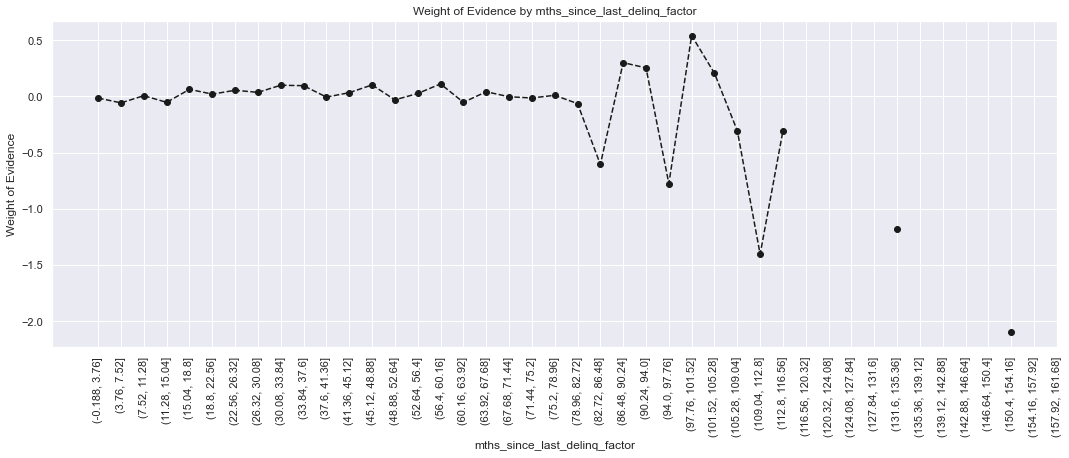

In [129]:
plot_by_woe(df_temp, 90)

From the graph, We'll group the following categories based on WoE values and number of observations:
- <15
- 15-37 months
- 37-63 months
- 63> months

In [131]:
X_train['mths_since_last_delinq:<15'] = np.where((X_train['mths_since_last_delinq'] >= 0) & (X_train['mths_since_last_delinq'] < 15), 1, 0)
X_train['mths_since_last_delinq:15-37'] = np.where((X_train['mths_since_last_delinq'] >= 15) & (X_train['mths_since_last_delinq'] < 37), 1, 0)
X_train['mths_since_last_delinq:37-63'] = np.where((X_train['mths_since_last_delinq'] >= 37) & (X_train['mths_since_last_delinq'] < 63), 1, 0)
X_train['mths_since_last_delinq:>=63'] = np.where((X_train['mths_since_last_delinq'] >= 63), 1, 0)

#### For our model we'll use:
- all the dummy variables of the grade column, and keep the category with the worst category as the reference category, which is grade:G.
- categories in the home_ownership variable -- home_ownership:OWN, home_ownership:MORTGAGE, and keep the home_ownership:RENT_OTHER_NONE category as the reference category.
- categories in the addr_state variable -- addr_state:NY, addr_state:NH_WV_WY_DC_ME, addr_state:MD_OK, addr_state:NY, addr_state:NM_AR_NC_VA_NJ_LA, addr_state:CA, addr_state:MO_RI_DE_AZ_TN_ID_MI, addr_state:OH_MA_KY_UT_PA, addr_state:MN_SD_IN_GA_WA, addr_state:OR_WI, addr_state:IL_MS_CO, addr_state:VT_CT_KS_MT_SC_AK, and keep the addr_state:ND_NE_IA_NV_FL_HI_AL category as the reference category.
- categories in the emp_length_int variable -- emp_length_int:1, emp_length_int:2-4, emp_length_int:5-6, emp_length_int:7-9, emp_length_int:10, and keep the emp_length_int:0 category as the reference category.
- categories in the mnths_since_issue_date variable -- mnths_since_issue_date:38-39, mnths_since_issue_date:40-41, mnths_since_issue_date:42-48, mnths_since_issue_date:49-52, mnths_since_issue_date:53-64, mnths_since_issue_date:65-84, mnths_since_issue_date:>84, and keep the mnths_since_issue_date:<38 category as the reference category.
- categories in the int_rate variable -- int_rate:9.548-12.025, int_rate:12.025-15.74, int_rate:15.74-20.281, int_rate:>20.281, and keep the int_rate:<9.548 category as the reference category.
- categories in the annual_inc variable -- annual_inc:20k-30k, annual_inc:30k-40k, annual_inc:40k-50, annual_inc:50k-60k, annual_inc:60k-70k, annual_inc:70k-80k, annual_inc:80k-90k, annual_inc:90k-100k, annual_inc:100k-120k, annual_inc:120k-150k, annual_inc:>150k, and keep the annual_inc:<20k category as the reference category.
- categories in the mths_since_last_delinq variable --mths_since_last_delinq:15-37, mths_since_last_delinq:37-63, mths_since_last_delinq:>=63, and keep the mths_since_last_delinq:<15 category as the reference category.

#### Preprocessing the Test data

We'll do the same preprocessing steps done on the train data.

In [132]:
#home ownership column
X_test['home_ownership:RENT_OTHER_NONE'] = sum([X_test['home_ownership:RENT'], X_test['home_ownership:OTHER'],
                                               X_test['home_ownership:NONE']])

In [133]:
#address column
if ['addr_state:ND'] in X_test.columns.values:
    pass
else:
    X_test['addr_state:ND'] = 0
    
X_test['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_test['addr_state:ND'], X_test['addr_state:NE'], X_test['addr_state:IA'],
                                                  X_test['addr_state:NV'], X_test['addr_state:FL'], X_test['addr_state:HI'],
                                                  X_test['addr_state:AL']])
X_test['addr_state:NH_WV_WY_DC_ME'] = sum([X_test['addr_state:NH'], X_test['addr_state:WV'], X_test['addr_state:WY'],
                                            X_test['addr_state:DC'], X_test['addr_state:ME']])
X_test['addr_state:MD_OK'] = sum([X_test['addr_state:MD'], X_test['addr_state:OK']])
X_test['addr_state:NM_AR_NC_VA_NJ_LA'] = sum([X_test['addr_state:NM'], X_test['addr_state:AR'], X_test['addr_state:NC'],
                                               X_test['addr_state:VA'], X_test['addr_state:NJ'], X_test['addr_state:LA']])
X_test['addr_state:MO_RI_DE_AZ_TN_ID_MI'] = sum([X_test['addr_state:MO'], X_test['addr_state:RI'], X_test['addr_state:DE'],
                                                  X_test['addr_state:AZ'], X_test['addr_state:TN'], X_test['addr_state:ID'],
                                                  X_test['addr_state:MI']])
X_test['addr_state:OH_MA_KY_UT_PA'] = sum([X_test['addr_state:OH'], X_test['addr_state:MA'], X_test['addr_state:KY'],
                                            X_test['addr_state:UT'], X_test['addr_state:PA']])
X_test['addr_state:MN_SD_IN_GA_WA'] = sum([X_test['addr_state:MN'], X_test['addr_state:SD'], X_test['addr_state:IN'],
                                            X_test['addr_state:GA'], X_test['addr_state:WA']])
X_test['addr_state:OR_WI'] = sum([X_test['addr_state:OR'], X_test['addr_state:WI']])
X_test['addr_state:IL_MS_CO'] = sum([X_test['addr_state:IL'], X_test['addr_state:MS'], X_test['addr_state:CO']])
X_test['addr_state:VT_CT_KS_MT_SC_AK'] = sum([X_test['addr_state:VT'], X_test['addr_state:CT'], X_test['addr_state:KS'],
                                               X_test['addr_state:MT'], X_test['addr_state:SC'], X_test['addr_state:AK']])

In [134]:
#term column
X_test['term:36'] = np.where((X_test['term_int'] == 36), 1, 0)
X_test['term:60'] = np.where((X_test['term_int'] == 60), 1, 0)

In [135]:
#emp_length column
X_test['emp_length_int:0'] = np.where((X_test['emp_length_int'].isin([0])), 1, 0)
X_test['emp_length_int:1'] = np.where((X_test['emp_length_int'].isin([1])), 1, 0)
X_test['emp_length_int:2-4'] = np.where((X_test['emp_length_int'].isin(range(2, 5))), 1, 0)
X_test['emp_length_int:5-6'] = np.where((X_test['emp_length_int'].isin(range(5, 7))), 1, 0)
X_test['emp_length_int:7-9'] = np.where((X_test['emp_length_int'].isin(range(7, 10))), 1, 0)
X_test['emp_length_int:10'] = np.where((X_test['emp_length_int'].isin([10])), 1, 0)

In [136]:
#mnths_since_issue_date column
X_test['mnths_since_issue_date:<38'] = np.where((X_test['mnths_since_issue_date'].isin(range(38))), 1, 0)
X_test['mnths_since_issue_date:38-39'] = np.where((X_test['mnths_since_issue_date'].isin(range(38, 40))), 1, 0)
X_test['mnths_since_issue_date:40-41'] = np.where((X_test['mnths_since_issue_date'].isin(range(40, 42))), 1, 0)
X_test['mnths_since_issue_date:42-48'] = np.where((X_test['mnths_since_issue_date'].isin(range(42, 49))), 1, 0)
X_test['mnths_since_issue_date:49-52'] = np.where((X_test['mnths_since_issue_date'].isin(range(49, 53))), 1, 0)
X_test['mnths_since_issue_date:53-64'] = np.where((X_test['mnths_since_issue_date'].isin(range(53, 65))), 1, 0)
X_test['mnths_since_issue_date:65-84'] = np.where((X_test['mnths_since_issue_date'].isin(range(65, 85))), 1, 0)
X_test['mnths_since_issue_date:>84'] = np.where((X_test['mnths_since_issue_date'].isin(range(85, int(X_test['mnths_since_issue_date'].max())))), 1, 0)

In [137]:
#int_rate column
X_test['int_rate:<9.548'] = np.where((X_test['int_rate'] <= 9.548), 1, 0)
X_test['int_rate:9.548-12.025'] = np.where((X_test['int_rate'] > 9.548) & (X_test['int_rate'] < 12.025), 1, 0)
X_test['int_rate:12.025-15.74'] = np.where((X_test['int_rate'] > 12.025) & (X_test['int_rate'] < 15.74), 1, 0)
X_test['int_rate:15.74-20.281'] = np.where((X_test['int_rate'] > 15.74) & (X_test['int_rate'] < 20.281), 1, 0)
X_test['int_rate:>20.281'] = np.where((X_test['int_rate'] > 20.281), 1, 0)

In [138]:
#annual_inc column
X_test['annual_inc:<20k'] = np.where((X_test['annual_inc'] <= 20000), 1, 0)
X_test['annual_inc:20k-30k'] = np.where((X_test['annual_inc'] > 20000) & (X_test['annual_inc'] <= 30000), 1, 0)
X_test['annual_inc:30k-40k'] = np.where((X_test['annual_inc'] > 30000) & (X_test['annual_inc'] <= 40000), 1, 0)
X_test['annual_inc:40k-50k'] = np.where((X_test['annual_inc'] > 40000) & (X_test['annual_inc'] <= 50000), 1, 0)
X_test['annual_inc:50k-60k'] = np.where((X_test['annual_inc'] > 50000) & (X_test['annual_inc'] <= 60000), 1, 0)
X_test['annual_inc:60k-70k'] = np.where((X_test['annual_inc'] > 60000) & (X_test['annual_inc'] <= 70000), 1, 0)
X_test['annual_inc:70k-80k'] = np.where((X_test['annual_inc'] > 70000) & (X_test['annual_inc'] <= 80000), 1, 0)
X_test['annual_inc:80k-90k'] = np.where((X_test['annual_inc'] > 80000) & (X_test['annual_inc'] <= 90000), 1, 0)
X_test['annual_inc:90k-100k'] = np.where((X_test['annual_inc'] > 90000) & (X_test['annual_inc'] <= 100000), 1, 0)
X_test['annual_inc:100k-120k'] = np.where((X_test['annual_inc'] > 100000) & (X_test['annual_inc'] <= 120000), 1, 0)
X_test['annual_inc:120k-150k'] = np.where((X_test['annual_inc'] > 120000) & (X_test['annual_inc'] <= 150000), 1, 0)
X_test['annual_inc:>150k'] = np.where((X_test['annual_inc'] > 150000), 1, 0)

In [139]:
#mths_since_last_delinq column
X_test['mths_since_last_delinq:<15'] = np.where((X_test['mths_since_last_delinq'] >= 0) & (X_test['mths_since_last_delinq'] < 15), 1, 0)
X_test['mths_since_last_delinq:15-37'] = np.where((X_test['mths_since_last_delinq'] >= 15) & (X_test['mths_since_last_delinq'] < 37), 1, 0)
X_test['mths_since_last_delinq:37-63'] = np.where((X_test['mths_since_last_delinq'] >= 37) & (X_test['mths_since_last_delinq'] < 63), 1, 0)
X_test['mths_since_last_delinq:>=63'] = np.where((X_test['mths_since_last_delinq'] >= 63), 1, 0)

In [141]:
X_train.shape, X_test.shape

((373028, 213), (93257, 208))